In [74]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


## Interpolation With Multiple output Hierachical GPs and comparison with simple Multiple output GPs

Initially one use the generative model of the hierarchical GP to  sample the observed signals

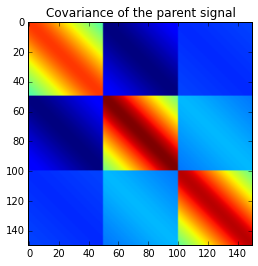

In [75]:
d = 3 # Output dimensions
time_stamps = 50 # amount of inputs
kg = GPy.kern.Matern32(1, variance=1., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
kf = GPy.kern.Matern32(1, variance=.01, lengthscale=2.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
x_parent = np.linspace(0, 2*np.pi, time_stamps)
inp = x_parent[:, None]
T = np.r_[np.c_[inp, np.zeros_like(inp)]]
for i in range(1,d):
    T = np.r_[T, np.c_[inp, np.ones_like(inp)*i]]

C_parent_gen = kg.K(T, None)
plt.imshow(C_parent_gen)
plt.title('Covariance of the parent signal')

(50,) (50,)


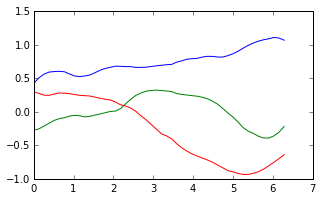

In [76]:
g_mean = np.zeros(T.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
divs = np.linspace(0,d*time_stamps, d + 1)
print T[0:50,0].shape, g_n[0, 0:50].shape
pb.figure(1, figsize=(5,3))
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    pb.plot(T[a:b,0], g_n[0,a:b])

The children signals are generated using the parent signal as mean

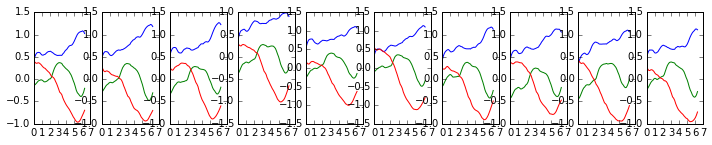

In [108]:
n_sons = 10
fn_list = []
C_sons_gen = kf.K(T, None)
g_n = g_n.squeeze()
plt.figure(i, figsize=(12,2))
for i in range(0,n_sons):
    f_n = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    f_n = np.squeeze(f_n)
    fn_list.append(f_n)    
    pb.subplot(1,n_sons,i + 1)
    for j in range(0, divs.shape[0] - 1):        
        a = divs[j]
        b = divs[j+1]
        pb.plot(T[a:b,0], f_n[a:b])

### Training the model

For testing the interpolation we must use a training/test data set, for this case, we will use a cross validation of five partitions over the input set

In [109]:
def ComputeMSQERR(a,b): # Mean Squared Error
    mean_sq_err = a - b
    mean_sq_err = np.power(mean_sq_err, 2)
    val_mean_sq_err = np.sum(mean_sq_err) / mean_sq_err.shape[0]
    return val_mean_sq_err

def ComputeSMSE(F, Y, var): # Standarized mean squared error
    mean_sq_err = Y - F
    mean_sq_err = np.power(mean_sq_err, 2)
    all_var = np.sum(var)
    sms_err = mean_sq_err/all_var
    val_smse = np.sum(sms_err)/F.shape[0]
    return val_smse

def ComputeSLL(F, Y, var, gaussian_noise_var): # Standarized Log Losss
    #print gaussian_noise_var.shape
    mean_sq_err = Y - F
    var = var + gaussian_noise_var
    mean_sq_err = np.power(mean_sq_err, 2)
    mean_sq_err = np.divide(mean_sq_err, 2.0*var)
    log_term = 0.5*np.log(var*2.0*np.pi)
    sll = log_term + mean_sq_err
    val_sll = np.sum(sll)/F.shape[0]
    return -1.0*val_sll

def SetInputMOHGP(sub_data_list, minp, multioutput_alone=0):
    ini_x = sub_data_list[0]
    inp = minp[0]
    #inp = np.arange(ini_x.shape[1])
    ini_T = np.r_[np.c_[inp, np.zeros_like(inp)]]
    ini_Y = np.r_[np.c_[ini_x[0,:]]]
    for i in range(1,ini_x.shape[0]):
        ini_T = np.r_[ini_T, np.c_[inp, np.ones_like(inp)*i]]
        ini_Y = np.r_[ini_Y, np.c_[ini_x[i,:]]]
    
    tmp_mlast = ini_x.shape[0]
    #ini_T.dtype = 'float64'
    T_hat = np.c_[ini_T, np.zeros_like(ini_T[:,1])]
    Y_hat = ini_Y
    for i in range(1,len(sub_data_list)):
        mdata = sub_data_list[i]
        mlast = tmp_mlast
        #inp = np.arange(mdata.shape[1])
        inp = minp[i]
        tmp_T = np.r_[np.c_[inp, np.ones_like(inp)*multioutput_alone*mlast]]
        #tmp_T.dtype = 'float64'
        tmp_Y = np.r_[np.c_[mdata[0,:]]]
        #print mlast
        for j in range(1,mdata.shape[0]):
            #print j
            tmp_T = np.r_[tmp_T, np.c_[inp, np.ones_like(inp)*j + (multioutput_alone*mlast)]]
            tmp_Y = np.r_[tmp_Y, np.c_[mdata[j,:]]]
            tmp_mlast += 1
        tmp_mlast += 1
        T_hat = np.r_[T_hat, np.c_[tmp_T, np.ones_like(tmp_T[:,1])*i]]
        Y_hat = np.r_[Y_hat, np.c_[tmp_Y]]
    
    return T_hat, Y_hat

def testTrainDataSet(l,r, fn_list, minp):    
    train_list = []
    test_list = []
    inp_train_list = []
    inp_test_list = []
    for mval in fn_list:
        index = np.random.permutation(time_stamps)
        bool_array_test = np.zeros(time_stamps, dtype=bool)
        bool_array_train = np.zeros(time_stamps, dtype=bool)
        bool_array_test[index[l:r]] = True
        bool_array_train = np.logical_not(bool_array_test)
        tmp_arr = np.zeros((d, time_stamps))
        a = 0
        b = time_stamps
        for i in range(0,d):
            tmp_arr[i,:] = mval[a:b]
            a = b
            b += time_stamps
            
        train_list.append(tmp_arr[:, bool_array_train])           
        test_list.append(tmp_arr[:, bool_array_test])    
        inp_train_list.append(minp[bool_array_train])
        inp_test_list.append(minp[bool_array_test])
    
    return train_list, test_list, inp_train_list, inp_test_list

def MOHGPmodel(T_hat, Y_hat, d):
    k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    k2 = GPy.kern.Matern32(1, variance=2., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    k1.name = 'parent'
    k2.name = 'children'
    kernels = [k1,k2] 
    HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)
    model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
    #model.likelihood.variance = 0.01
    model.optimize()
    #model.optimize_restarts(num_restarts = 20)
    return model

def ModelPredict(T_hat, model, kpred):
    mmean, mvar = model._raw_predict(T_hat, kern=kpred)
    return mmean, mvar

def MOGPmodel(T_hat, Y_hat, d):
    kern = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    #print T_hat
    model = GPy.models.GPRegression(T_hat, Y_hat, kern)
    model.optimize()
    #model.optimize_restarts(num_restarts = 20)
    return model

def crossValidation(fn_list, time_stamps, d, valid_num = 5):
    Ntest = (time_stamps/valid_num)
    Ntrain = time_stamps - Ntest
    #index = np.arange(time_stamps, dtype=int)
    minp = np.linspace(0, 2*np.pi, time_stamps)
    #for i in range(0, valid_num):
    l = 0
    r = 35
    msqerr_hgp = 0.0
    msqerr_mogp = 0.0
    
    # finding parameters of the model 
    _, train_list, _, inp_train = testTrainDataSet(0, time_stamps, fn_list, minp)
    T_hat_train, Y_hat_train = SetInputMOHGP(train_list, inp_train)
    model_mohgp = MOHGPmodel(T_hat_train, Y_hat_train, d)
    
    T_hat_train, Y_hat_train = SetInputMOHGP(train_list, inp_train, 1)
    mogp_dims = int(np.amax(T_hat_train[:,1])) + 1
    model_mogp = MOGPmodel(T_hat_train, Y_hat_train, mogp_dims) 
    
    
    for i in range(0, valid_num):
        print l,r
        train_list, test_list, inp_train, inp_test = testTrainDataSet(l, r, fn_list, minp)
        if i == 0:
            for j in range(0, len(train_list)):
                pb.figure(j, figsize=(12,2))
                for i in range(0, train_list[j].shape[0]):
                    pb.subplot(1, d, i)
                    y_plot_train = train_list[j][i,:] 
                    y_plot_test = test_list[j][i,:]
                    pb.plot(inp_train[j], y_plot_train, 'bx')
                    pb.plot(inp_test[j], y_plot_test, 'rx')
        #print train_list[0].shape
        T_hat_train, Y_hat_train = SetInputMOHGP(train_list, inp_train)
        T_hat_test, Y_hat_test = SetInputMOHGP(test_list, inp_test)
        kmohgp = model_mohgp.hierarchy.copy()
        mlso1 = GPy.models.gp_regression.GPRegression(T_hat_train, Y_hat_train, kmohgp)
        mlso1[:] = model_mohgp[:]
        #model_mohgp = MOHGPmodel(T_hat_train, Y_hat_train, d)
        mmean, mvar = ModelPredict(T_hat_test, mlso1, kmohgp)
        mtmp = ComputeMSQERR(mmean, Y_hat_test)
        msqerr_hgp += mtmp

        # Multioutput prediction
        T_hat_train, Y_hat_train = SetInputMOHGP(train_list, inp_train, 1)
        T_hat_train = T_hat_train[:,0:2]
        T_hat_test, Y_hat_test = SetInputMOHGP(test_list, inp_test, 1)
        T_hat_test = T_hat_test[:,0:2]
        mogp_dims = int(np.amax(T_hat_train[:,1])) + 1
        #model_mogp = MOGPmodel(T_hat_train, Y_hat_train, mogp_dims)
        kmogp = model_mogp.kern.copy()
        mlso2 = GPy.models.gp_regression.GPRegression(T_hat_train, Y_hat_train, kmogp)
        mlso2[:] = model_mogp[:]
        mmean, mvar = mlso2._raw_predict(T_hat_test)
        mtmp = ComputeMSQERR(mmean, Y_hat_test)
        msqerr_mogp += mtmp
    

    print 'mean squared error for MOHGP: ', msqerr_hgp/(valid_num - 1)
    print 'mean squared error for MOGP: ', msqerr_mogp/(valid_num - 1)
    

0 35
0 35
0 35
0 35
0 35
mean squared error for MOHGP:  0.000322042548216
mean squared error for MOGP:  0.00020062317524


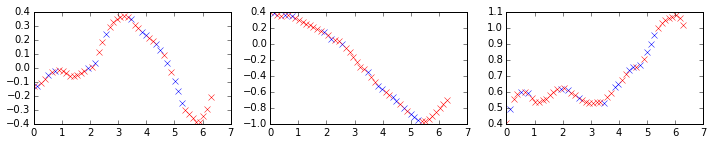

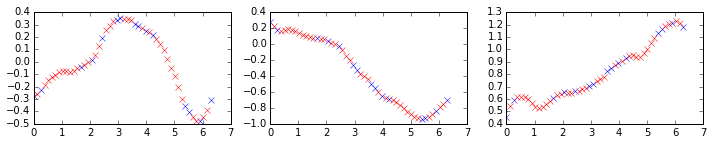

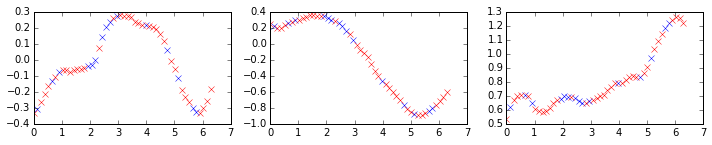

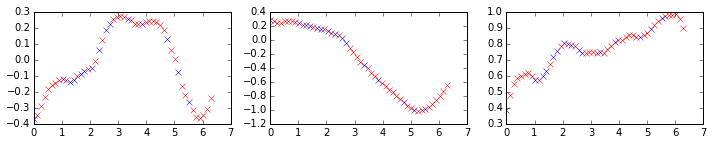

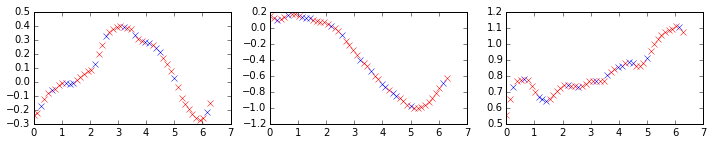

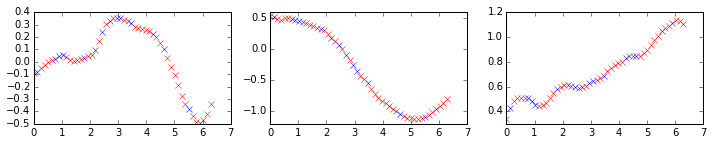

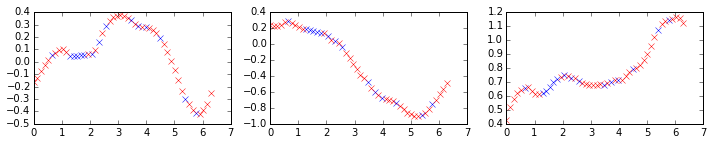

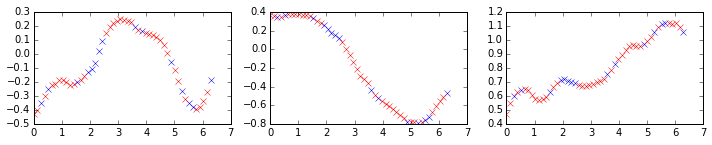

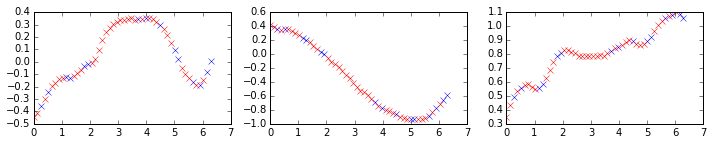

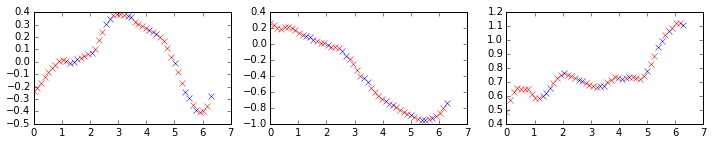

In [110]:
crossValidation(fn_list, time_stamps, d)

IT seems that there is a tendency for the MOHGP to be better than the MOGP when the amount of children signals is lower